Due to this video, I need to experiment a bit.

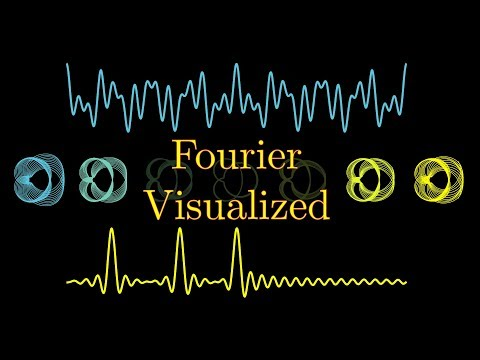

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('spUNpyF58BY')

Let's make a sine wave, as in the video:

In [2]:
import numpy as np

def make_sine(freq):
    """Returns (t, amp) of sine wave with input frequency."""
    dt = 1/(freq*50)
    t = np.arange(0, 4.5 + dt, dt)
    return t, (1 + np.cos(2 * np.pi * freq * t)) / 2

t, amp = make_sine(3)

And let's plot it.

In [3]:
import holoviews as hv
hv.extension('bokeh', logo=False)

hv.Curve((t, amp), kdims='t', vdims='pressure')

:Curve   [t]   (pressure)

Now, let's wrap this curve up in the manner suggested by the video. Each moment in time get's mapped to an angle and then the radius of that angle is the pressure from the above graph.

In [4]:
def time2angle(t, cycles_per_sec):
    """Converts time to an angle (in rad), at cycles_per_sec rate."""
    return t * cycles_per_sec * 2 * np.pi

time2angle(t, 0.5)[0:10]

array([0.        , 0.02094395, 0.0418879 , 0.06283185, 0.0837758 ,
       0.10471976, 0.12566371, 0.14660766, 0.16755161, 0.18849556])

Let's check that the last value is roughly equal to what we expect at 0.5 turns per second (i.e. 2 seconds are one turn or 2 $\pi$ and thus 4.5 secondes are 2.25 * $2 \pi$).

In [5]:
time2angle(t, 0.5)[-1], 2.25 * 2 * np.pi

(14.137166941154069, 14.137166941154069)

Good, now let's move on to that graph. We use the classic polar coordinate projection formula to get $(x,y)$ coordinates for plotting.

In [6]:
angles = time2angle(t, 0.5) # project time to angle
r = amp # use amplitude as the r coordinate in polar coords

# compute x and y using classical polar formula
x = r * np.cos(angles) 
y = r * np.sin(angles)

# plot it
hv.Curve((x, y))

:Curve   [x]   (y)

Nice! Let's see if we can make this a little bit interactive.

In [7]:
mappings = {}
for cycles_per_sec in np.linspace(0.2, 1.5, num=20):
    angles = time2angle(t, cycles_per_sec)
    r = amp
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    mappings[cycles_per_sec] = hv.Curve((x, y))
hv.output(hv.HoloMap(mappings, kdims='cycles_per_sec'), holomap='scrubber')

:HoloMap   [cycles_per_sec]
   :Curve   [x]   (y)

Let's make a more finely explorable diagram.

In [8]:
def almost_fourier(t, amp, freqs):
    almoust_fourier_transform = np.zeros_like(freqs, dtype=complex)

    for i, cycles_per_sec in enumerate(freqs):
        angles = time2angle(t, cycles_per_sec)
        r = amp
        x = r * np.cos(angles)
        y = r * np.sin(angles)
        center_of_mass = np.array([x.mean(), y.mean()])
        almoust_fourier_transform[i] = center_of_mass[0] + 1j * center_of_mass[1]

    return almoust_fourier_transform

almost_fourier(t, amp, freqs=np.arange(0, 4.5, .01))[:10]

array([0.5       +0.j        , 0.49337989+0.0700738j ,
       0.47383473+0.13736824j, 0.44229225+0.19925076j,
       0.4002403 +0.25337363j, 0.3496431 +0.2977952j ,
       0.29283126+0.33107706j, 0.23237228+0.3523518j ,
       0.17092954+0.36135738j, 0.11111801+0.35843656j])

In [9]:
def plot_circle_mapping(cycles_per_sec):
    # circle mapping
    angles = time2angle(t, cycles_per_sec)
    r = amp
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    center_of_mass = np.array([x.mean(), y.mean()]).reshape(1, -1)
    mapping_curve = hv.Curve((x, y)).opts(xlim=(-1, 1), ylim=(-1, 1)) * hv.Scatter(center_of_mass).opts(size=10, color='red')
    
    # time curve with VLine
    n_blocks = int(t.max() * cycles_per_sec ) 
    vlines = [hv.VLine(val).opts(color='gray') for val in np.arange(n_blocks + 1) / cycles_per_sec if val > 0]
    time_curve = hv.Curve((t, amp), kdims='t', vdims='pressure') * hv.Overlay(vlines)
    
    # almost Fourier transform
    freqs = np.arange(0, 4.5, .01)
    almoust_fourier_transform = almost_fourier(t, amp, freqs=freqs)
    almost_fourier_curve = hv.Curve((freqs, almoust_fourier_transform.real), kdims='freq', vdims='freq amp') * hv.VLine(cycles_per_sec) * hv.Scatter((cycles_per_sec, center_of_mass[0, 0])).opts(size=10, color='red')
    return (time_curve + mapping_curve + almost_fourier_curve)

dmap = hv.DynamicMap(plot_circle_mapping, kdims=['cycles_per_sec']).redim.range(cycles_per_sec=(0., 4.5)).redim.step(cycles_per_sec=0.01)
dmap

C:\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


:DynamicMap   [cycles_per_sec]
   :Layout
      .Overlay.I   :Overlay
         .Curve.I :Curve   [t]   (pressure)
      .Overlay.II  :Overlay
         .Curve.I   :Curve   [x]   (y)
         .Scatter.I :Scatter   [x]   (y)
      .Overlay.III :Overlay
         .Curve.I   :Curve   [freq]   (freq amp)
         .VLine.I   :VLine   [x,y]
         .Scatter.I :Scatter   [x]   (y)

We can reproduce some of the interesting plots.

In [10]:
dmap[3] # everything aligns and the center of mass sticks out

:Layout
   .Overlay.I   :Overlay
      .Curve.I    :Curve   [t]   (pressure)
      .VLine.I    :VLine   [x,y]
      .VLine.II   :VLine   [x,y]
      .VLine.III  :VLine   [x,y]
      .VLine.IV   :VLine   [x,y]
      .VLine.V    :VLine   [x,y]
      .VLine.VI   :VLine   [x,y]
      .VLine.VII  :VLine   [x,y]
      .VLine.VIII :VLine   [x,y]
      .VLine.IX   :VLine   [x,y]
      .VLine.X    :VLine   [x,y]
      .VLine.XI   :VLine   [x,y]
      .VLine.XII  :VLine   [x,y]
      .VLine.XIII :VLine   [x,y]
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [freq]   (freq amp)
      .VLine.I   :VLine   [x,y]
      .Scatter.I :Scatter   [x]   (y)

In [11]:
dmap[1.5]

:Layout
   .Overlay.I   :Overlay
      .Curve.I   :Curve   [t]   (pressure)
      .VLine.I   :VLine   [x,y]
      .VLine.II  :VLine   [x,y]
      .VLine.III :VLine   [x,y]
      .VLine.IV  :VLine   [x,y]
      .VLine.V   :VLine   [x,y]
      .VLine.VI  :VLine   [x,y]
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [freq]   (freq amp)
      .VLine.I   :VLine   [x,y]
      .Scatter.I :Scatter   [x]   (y)

In [12]:
dmap[4.5]

:Layout
   .Overlay.I   :Overlay
      .Curve.I     :Curve   [t]   (pressure)
      .VLine.I     :VLine   [x,y]
      .VLine.II    :VLine   [x,y]
      .VLine.III   :VLine   [x,y]
      .VLine.IV    :VLine   [x,y]
      .VLine.V     :VLine   [x,y]
      .VLine.VI    :VLine   [x,y]
      .VLine.VII   :VLine   [x,y]
      .VLine.VIII  :VLine   [x,y]
      .VLine.IX    :VLine   [x,y]
      .VLine.X     :VLine   [x,y]
      .VLine.XI    :VLine   [x,y]
      .VLine.XII   :VLine   [x,y]
      .VLine.XIII  :VLine   [x,y]
      .VLine.XIV   :VLine   [x,y]
      .VLine.XV    :VLine   [x,y]
      .VLine.XVI   :VLine   [x,y]
      .VLine.XVII  :VLine   [x,y]
      .VLine.XVIII :VLine   [x,y]
      .VLine.XIX   :VLine   [x,y]
      .VLine.XX    :VLine   [x,y]
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [freq]   (freq amp)
      .VLine.I   :VLine   [x,y]
      .Scatter.I :Scatter   [x]   (y)

In [13]:
dmap[3.1]

:Layout
   .Overlay.I   :Overlay
      .Curve.I    :Curve   [t]   (pressure)
      .VLine.I    :VLine   [x,y]
      .VLine.II   :VLine   [x,y]
      .VLine.III  :VLine   [x,y]
      .VLine.IV   :VLine   [x,y]
      .VLine.V    :VLine   [x,y]
      .VLine.VI   :VLine   [x,y]
      .VLine.VII  :VLine   [x,y]
      .VLine.VIII :VLine   [x,y]
      .VLine.IX   :VLine   [x,y]
      .VLine.X    :VLine   [x,y]
      .VLine.XI   :VLine   [x,y]
      .VLine.XII  :VLine   [x,y]
      .VLine.XIII :VLine   [x,y]
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [freq]   (freq amp)
      .VLine.I   :VLine   [x,y]
      .Scatter.I :Scatter   [x]   (y)

In [14]:
dmap[4.4]

:Layout
   .Overlay.I   :Overlay
      .Curve.I     :Curve   [t]   (pressure)
      .VLine.I     :VLine   [x,y]
      .VLine.II    :VLine   [x,y]
      .VLine.III   :VLine   [x,y]
      .VLine.IV    :VLine   [x,y]
      .VLine.V     :VLine   [x,y]
      .VLine.VI    :VLine   [x,y]
      .VLine.VII   :VLine   [x,y]
      .VLine.VIII  :VLine   [x,y]
      .VLine.IX    :VLine   [x,y]
      .VLine.X     :VLine   [x,y]
      .VLine.XI    :VLine   [x,y]
      .VLine.XII   :VLine   [x,y]
      .VLine.XIII  :VLine   [x,y]
      .VLine.XIV   :VLine   [x,y]
      .VLine.XV    :VLine   [x,y]
      .VLine.XVI   :VLine   [x,y]
      .VLine.XVII  :VLine   [x,y]
      .VLine.XVIII :VLine   [x,y]
      .VLine.XIX   :VLine   [x,y]
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [freq]   (freq amp)
      .VLine.I   :VLine   [x,y]
      .Scatter.I :Scatter   [x]   (y)